# Working with Data

## The importance of exploration

One of the first things that we do when working with any new data set is to familiarise ourselves with it. There are a _huge_ number of ways to do this, but there are no shortcuts to:
* Reading about the data (how it was collected, what the sample size was, etc.)
* Reviewing any accompanying metadata (data about the data, column specs, etc.)
* Looking at the data itself at the row- and column-levels
* Producing descriptive statistics 
* Visualising the data using plots 
In fact, you should use _all_ of these together to really understand where the data came from, how it was handled, and whether there are gaps or other problems. If you're wondering which comes first, I've always liked this approach: _start with a chart_. We're _not_ going to do that here because, first, I want you to get a handle on pandas itself!

## Pandas with Weather API Data 

The UK's Met Office is a world-leading weather and climate research centre, and even if it doesn't always seem like their forecasts are very accurate that's because Britain's weather is inherently _unpredictable_. They've also done a lot of work to make their weather data widely available to people like us.

I probably don't need to say a _lot_ about weather data because you've probably been making use of forecasts for much of your life! But it's _still_ worth understanding something about how weather data is gathered and reported: many organisations operate weather stations where data on wind speed, temperature, rain, and amount of sun are collected and then transmitted to a server to be integrated into a larger data set of weather _observations_ at a national or global scale. Of course, any _one_ station might be in the 'wrong' place (somewhere shady or protected from the rain) or it might even break down, but the idea is that if you have enough of them you can collect a pretty good range of data for the country and begin to look for patterns and, potentially, make predictions.

We will be accessing data from the MetOffice from weather stations where observations, such as the ones below, are collected:
* <Param name="F" units="C">Feels Like Temperature (units: degrees Celsius)
* <Param name="G" units="mph">Wind Gust (units: mph)</Param>
* <Param name="H" units="%">Screen Relative Humidity (units: percent)</Param> 
* <Param name="T" units="C">Temperature (units: degrees Celsius)</Param> 
* <Param name="V" units="">Visibility (units: km?)</Param> 
* <Param name="D" units="compass">Wind Direction (units: compass degrees)</Param>  
* <Param name="S" units="mph">Wind Speed (units: mph)</Param> 
* <Param name="U" units="">Max UV Index (units: index value)</Param> 
* <Param name="W" units="">Weather Type (units: categorical)</Param> 
* <Param name="Pp" units="%">Precipitation Probability (units: percent)</Param>

These observations are associated with a particular station (where did we see these values/where _will_ we see these values?), they will also be associated with _either_ a particular time in the past (when were they collected?) or, if they're forecasts, with a particular time in the future (when do we expect to see them?). 

So although weather data might seem more 'objective' than data on social class (though for obvious reasons it turns out that both are just attempts to capture data about reality, not reality itself), it may also turn out to be very complex to store and manage beccause of the temporal element _and_ the fact that it's not just a count of one thing, each of these observations uses a very different set of units.

To really get to grips with the MetOffice API you will need to RTM (Read The Manual): http://www.metoffice.gov.uk/media/pdf/3/0/DataPoint_API_reference.pdf. The ruder version of that, which you will sometimes see on StackOverflow and elsewhere, is: RTFM.

## Getting Weather Data via an API

Because the weather is changing all the time, so is the data! And, 'worse', it's becoming obsolete: the forecast from 2 years ago isn't particularly useful to us now. *And* asking for "yesterday's weather" depends on the day that we're asking! When you have data that is always changing from minute to minute or day to day then you use an API (Application Programming Interface) to access it: the API knows that "yesterday's weather" means "work out what day it is right now and then get the weather from the day before", and it also knows that "give me the current weather from station X" means "look up station X and find the latest weather report that I've received". In other words, an API is  designed with programmatic, dynamic interaction in mind right from the start.

### So What _is_ an API?

There's a nice, friendly introduction to APIs over at [Free Code Camp](https://medium.freecodecamp.com/what-is-an-api-in-english-please-b880a3214a82#.rmjnli2nn). You can combine this with watching a video from MuleSoft that compares an API with a waiter in a restaurant:

[![What is an API?](http://img.youtube.com/vi/s7wmiS2mSXY/0.jpg)](https://www.youtube.com/watch?v=s7wmiS2mSXY)

Helpfully, the MetOffice provides a lot of documentation about their API (I'd suggest bookmarking it): http://www.metoffice.gov.uk/datapoint/support/api-reference

This type of data requires a lot more research up front to work with, but it's very flexible once you know how to 'speak API' because you can _customise_ the API request so that the server responds with _only_ the data we're interested in instead of being 'stuck' with what the provider wants to give us.

### Obtaining an API Key

The first step to working with the API from the MetOffice is to obtain an API key: [do that here](http://www.metoffice.gov.uk/datapoint/API). 

Make a note of this key in your notebook. Right here:

In [1]:
api_key   = "..." # your API key

That way your API key is saved somewhere easy to access.

We _always_ have to use the key as part of an API request: the process by which we _ask_ for data. Think of the key as being _your_ unique identifier: no two people share the same key and that way the MetOffice can cut off people who abuse the system or look at which APIs are popular with lots of users... Twitter and Facebook do the same thing.

In [24]:
# We don't want to output the API key since 
# that is personal to each user
def scrub_api_key(text, key=api_key):
    return text.replace(key, 'XXXXXX')

## Obtaining a List of Sites from the API

How to start? Well, the first thing that we need to know is: for what locations can I get weather data? For this to work, we need to know how to ask the API nicely for a list of available sites... We're going to show you the code and output _first_ and then we'll step through what's involved. You won't see any output from the code in the next block because we look at that later.

In [2]:
import json, requests # Libraries we need

api_url  = "http://datapoint.metoffice.gov.uk/public/data/" # base URL
site_url = "val/wxfcs/all/json/sitelist" # sites API URL

payload = {'key': api_key} # Dictionary to hold request parameters
s = requests.get(api_url + site_url, params=payload) # Do the request

sites = s.json() # Capture the output

print("Done!")

Done!


OK, now let's try making sense of the JSON code:
```python
import json, requests
```
So, first we import two new modules: one that makes requests to a web server, and one that will parse JSON\* responses from the server in order to turn them into something that we can work with more easily.

\* We'll get to what JSON is in a second.

```python
api_url  = "http://datapoint.metoffice.gov.uk/public/data/" # base URL
site_url = "val/wxfcs/all/json/sitelist" # sites API URL
```

Then we set up some default variables (`api_url`, `site_url`) that will help us to build our request to the MetOffice's server. The comments help us to remember what each of these variables holds.

```python
payload = {'key': api_key} # Dictionary to hold request parameters
s = requests.get(api_url + site_url, params=payload) # Do the request
```

You'll notice that the `payload` is just a dictionary and that this dictionary is then passed to the `requests` library (the `get` function). All it does it convert this dictionary to a key-value pair in the format _expected by the API_. Think of it as a kind of translation between languages: from the language of Python to the language of the web (HTTP, to be precise).

We issue our request and it returns a response that we store in `s` (short for `sites data`).

```python
sites = s.json() # Capture the output
```

Lastly, we ask the response object to convert the reply into a JSON data structure... more on JSON in a second, but first let's look at what we got from our request!

In [25]:
# Show the requested URL
print(scrub_api_key(s.url)) # Click on the link below to see it nicely formatted automatically!

http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/json/sitelist?key=XXX


In [7]:
# Capture the returned data
print(str(sites)[0:2500] + "...")

{'Locations': {'Location': [{'elevation': '50.0', 'id': '14', 'latitude': '54.9375', 'longitude': '-2.8092', 'name': 'Carlisle Airport', 'region': 'nw', 'unitaryAuthArea': 'Cumbria'}, {'elevation': '22.0', 'id': '26', 'latitude': '53.3336', 'longitude': '-2.85', 'name': 'Liverpool John Lennon Airport', 'region': 'nw', 'unitaryAuthArea': 'Merseyside'}, {'elevation': '25.0', 'id': '33', 'latitude': '60.4322', 'longitude': '-1.2992', 'name': 'Scatsta', 'region': 'os', 'unitaryAuthArea': 'Shetland Islands'}, {'elevation': '7.0', 'id': '3066', 'latitude': '57.6494', 'longitude': '-3.5606', 'name': 'Kinloss', 'region': 'gr', 'unitaryAuthArea': 'Moray'}, {'elevation': '6.0', 'id': '3068', 'latitude': '57.712', 'longitude': '-3.322', 'obsSource': 'LNDSYN', 'name': 'Lossiemouth', 'region': 'gr', 'unitaryAuthArea': 'Moray'}, {'elevation': '36.0', 'id': '3075', 'latitude': '58.454', 'longitude': '-3.089', 'obsSource': 'LNDSYN', 'name': 'Wick John O Groats Airport', 'region': 'he', 'unitaryAuthAre

### So, What's JSON?

It's pretty hard to figure out what that 'JSON' reply means, but if you look closely you'll start to see a few things that you recognise:

1. There is the '{' and '}' that we associate with dictionaries
2. There is the ':' that we associate with key-value pairs in dictionaries
3. The really hard thing is all the extra 'u's all over the place but that's something that's confusing to _us_, not the _computer_.

So it's actually just a kind of dictionary containing lists and other dictionaries. That's it. The output looks like a mess, but it _is_ a dictionary and the only thing that is entirely new is the fact that every string has the letter 'u' in front of it. 

That 'u' means 'Unicode' and it just a special kind of string that supports accents, Chinese characters, emojis, and just about anything else that you can think of...

### Using XML to better understand JSON

We want to work with JSON replies because they are easier for Python to read, but sometimes it is easier for _us_ to read the output of an API if we are able to ask for the answer in XML (eXtensible Markup Language). Try running the code block below and then copy+pasting the URL that it outputs into your browser window:

In [26]:
xml_url = "val/wxfcs/all/xml/sitelist"
x = requests.Request('GET', api_url + xml_url, params=payload).prepare()
print(scrub_api_key(x.url))

http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/xml/sitelist?key=XXX


### Back to JSON...

Now that you have a better idea of what data the reply contains, let's see if we can convert the JSON reply into something useful for Python; if you scroll back up to where we printed out the reply you'll notice that it all starts with a '{', meaning that it's a dictionary.

Let's start by printing out the keys in the dictionary and the _type_ of data associated as a value to that key:

In [9]:
for k in sites.keys():
    print("Key: " + str(k))
    print("Value: " + str(type(sites[k])))

Key: Locations
Value: <class 'dict'>


Not the most exciting answer, but at least we know that the value is a dictionary. Let's try moving down a level:

In [10]:
for k in sites.keys():
    print("Key: " + str(k))
    print("Value: " + str(type(sites[k])))
    for k2 in sites[k].keys():
        print("\tKey: " + str(k2))
        print("\tValue: " + str(type(sites[k][k2])))

Key: Locations
Value: <class 'dict'>
	Key: Location
	Value: <class 'list'>


The MetOffice is not making life easy for us here: there's a _lot_ of extra 'baggage' in this API response. But we at least know that the next level down is a list and _that_ suggests that things are about to get a bit more interesting... Let's simplify our code at the same time:

In [11]:
apiList = sites['Locations']['Location']
print("List in API response is " + str(len(apiList)) + " long")

List in API response is 6003 long


Now _that_ is a rather more interesting response. What it means is that our JSON reply has this structure:
```
{
    'Locations': {
        'Location': [
            ... lots of data here ...
        ]
    }
}
```

If you scroll back up to the JSON reply you should now be able to read a little bit more of the response... and this should give you a clue as to how to print out the `name`, `id`, and `longitude` of the first five sites. I'll get you started:

In [14]:
for i in range(10):
    location = apiList[i]
    print("Location: " + location['name'] + 
          " (id: " + location['id'] + 
          ") is at longitude: " + 
          location['longitude'])
    

Location: Carlisle Airport (id: 14) is at longitude: -2.8092
Location: Liverpool John Lennon Airport (id: 26) is at longitude: -2.85
Location: Scatsta (id: 33) is at longitude: -1.2992
Location: Kinloss (id: 3066) is at longitude: -3.5606
Location: Lossiemouth (id: 3068) is at longitude: -3.322
Location: Wick John O Groats Airport (id: 3075) is at longitude: -3.089
Location: Braemar (id: 3081) is at longitude: -3.397
Location: Baltasound (id: 3002) is at longitude: -0.854
Location: Lerwick (S. Screen) (id: 3005) is at longitude: -1.183
Location: Fair Isle (id: 3008) is at longitude: -1.628


Your answer should look like this:

```python
Location: Carlisle Airport (id: 14) is at longitude: -2.8092
Location: Liverpool John Lennon Airport (id: 26) is at longitude: -2.85
Location: Scatsta (id: 33) is at longitude: -1.2992
Location: Kinloss (id: 3066) is at longitude: -3.5606
Location: Lossiemouth (id: 3068) is at longitude: -3.322
```

And _now_ that we know where all the data was 'hidden', we can convert this to a proper data structure in which it is possible to _interact_ with it. To do that, we'll put the site data into a pandas data frame...

# Turning API data into a Pandas DataFrame

Pandas is remarkably intelligent and will _often_ -- though not always -- work out the sensible thing to do from many kinds of data structures (list-of-lists, dictionary-of-lists, list-of-dictionaries...). So let's see what happens when we simply pass `apiList` (a LoD) directly to the `DataFrame` 'constructor' instead of passing the data through, for instance, the `read_csv` function as we did above with a CSV file.

In [16]:
import pandas as pd
df2 = pd.DataFrame(apiList)

df2.head()

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
0,50.0,14,54.9375,-2.8092,Carlisle Airport,nw,Cumbria,NaN,NaN
1,22.0,26,53.3336,-2.85,Liverpool John Lennon Airport,nw,Merseyside,NaN,NaN
2,25.0,33,60.4322,-1.2992,Scatsta,os,Shetland Islands,NaN,NaN
3,7.0,3066,57.6494,-3.5606,Kinloss,gr,Moray,NaN,NaN
4,6.0,3068,57.712,-3.322,Lossiemouth,gr,Moray,LNDSYN,NaN


Wow, that's... almost scarily easy. You can see that pandas worked out the structure of our LoD and then automatically converted that to columns in a data frame. So it got the hardest part of the process exactly right and has saved us a lot of work. _That_ is the point of functions and of code: to be constructively lazy.

Of course, we could have predicted that pandas would cope since there is a whole section in the documentaiton [devoted to creating data frames from different structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

But let's take a slightly closer look at the Elevation data:

In [17]:
df2.elevation.describe()

count     6002
unique     747
top        0.0
freq       590
Name: elevation, dtype: object

**What's that?** The data-type (dtype) is an _object_? Shouldn't that be a float? And shouldn't the description give us the 7-figure summary for numeric data? The 'problem' (if you looked closely at the JSON response) is that everything came back to us as Unicode text (the little 'u's in front of each key and value) and not as numbers.

## Fixing Column Data-types

The problem is that pandas didn't know what we expected the columns to be, so it's treated them all as 'objects' (basically: strings) and not as numeric data types. To fix that you need to know that there's a function called `'astype'` that allows pandas to convert between different data types where it's fairly easy for pandas to figure out what we want to do:

In [18]:
for c in ['region','unitaryAuthArea']:
    df2[c] = df2[c].astype('category')
for c in ['elevation','latitude','longitude']:
    df2[c] = df2[c].astype('float')
for c in ['id']:
    df2[c] = df2[c].astype('int')

Let's try that description again:

In [19]:
df2.elevation.describe()

count    6002.000000
mean      152.443186
std       251.881513
min        -2.000000
25%        18.000000
50%        64.000000
75%       140.000000
max      1344.000000
Name: elevation, dtype: float64

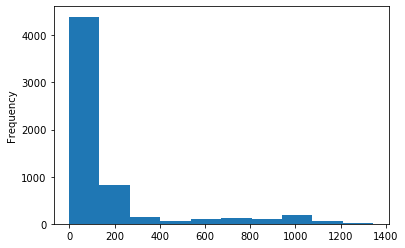

In [20]:
%matplotlib inline
df2.elevation.plot.hist()

### Investigating Unknown Columns

You'll note that I didn't change the column types for `name`, `nationalPark`, and `obsSource`. There's no reason to change the name since we rather _assume_ that it's pretty much unique (the output of `describe` confirms it). For the others, it's because we don't really know what we expect to find!

There's no 'one' way to investigate the values in an 'unknown' column, but it's often worth thinking about _unique_ values as a starting point.

In [21]:
print("Data type is: " + df2.nationalPark.dtype.name)
print(" ")
print(df2.nationalPark.describe())

Data type is: object
 
count                             618
unique                             16
top       Lake District National Park
freq                               94
Name: nationalPark, dtype: object


This tells us that there are 618 rows (out of nearly 6,000) that have a value that is _not_ `NaN`, and that there are 16 unique non-`NaN` values. We can list them easily in pandas:

In [22]:
df2.nationalPark.unique()

array([nan, 'Cairngorms National Park', 'Northumberland National Park',
       'Snowdonia National Park', 'South Downs National Park',
       'New Forest National Park', 'Yorkshire Dales National Park',
       'Peak District National Park', 'Exmoor National Park',
       'Lake District National Park', 'Pembrokeshire Coast National Park',
       'Dartmoor National Park',
       'Loch Lomond and the Trossachs National Park', 'The Mournes',
       'Brecon Beacons National Park', 'North York Moors National Park',
       'The Broads'], dtype=object)

Given the number of unique parks, what is the _best_ data-type for this column? Fix the code below to change the column type of the nationalPark data and assign the updated column it back to `nationalPark` in the block below:

In [27]:
df2['nationalPark'] = df2.nationalPark.astype('category')

And now let's check our data type:

In [28]:
print("Data type is: " + df2.nationalPark.dtype.name)

Data type is: category


# Finding Data in Pandas

We've got ourselves a pandas data frame containing a set of locations, how do we go about finding one or more _specific_ rows in the data set rather than just summarising the data via `describe`?

## Searching for a Number

This is the easiest type of search to do in pandas because it looks _most_ like code you've already seen.

### Find All Sites East of 1.1 Degrees Longitude

To translate this into code, we just need to remember that: a) East would be _greater than_; and b) longitude is already a float. So in that case it's...

In [29]:
dfEast = df2[df2.longitude > 1.1]
dfEast.head(7)

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
17,117.0,3796,51.1330,1.3480,Langdon Bay,se,Kent,NaN,NaN
83,6.0,310094,52.0563,1.1499,Ipswich,ee,Suffolk,NaN,NaN
144,15.0,324251,52.9311,1.3036,Cromer,ee,Norfolk,NaN,NaN
186,14.0,352254,52.2086,1.5759,Leiston,ee,Suffolk,NaN,NaN
192,0.0,352267,52.7996,1.5521,Lessingham,ee,Norfolk,NaN,NaN
243,9.0,352405,52.5321,1.4849,Loddon,ee,Norfolk,NaN,NaN
275,99.0,352469,51.1776,1.1977,Lydden Motor Racing Circuit,se,Kent,NaN,NaN


Let's break this down:

* `df2.longitude` is obviously the longitude column of our data frame `df2`
* `df2.longitude > 1.1` is therefore a kind of _query_ (or _selection_) of rows where the longitude is greater than 1.1. What it _actually_ does is compare each row's longitude value to 1.1 and remember if the result is `True` or `False`.
* `df2[ ... ]` is _like_ what we do with a list when we write: `myList[3:5]` to select the fourth through sixth elements of a list, but in pandas we can _select_ non-sequential rows because we are using a `boolean` array (a.k.a. list) that looks like this: `[False, False, False, True, True, True, ...]`.
* `dfEast = ...` saves the _result_ of the selection into a new data frame called `dfEast` (data frame East).

You can check what I'm saying about the boolean result using:

In [30]:
df2.longitude > 1.1

0       False
1       False
2       False
3       False
4       False
        ...  
5998    False
5999    False
6000    False
6001    False
6002    False
Name: longitude, Length: 6003, dtype: bool

And we can check that `dfEast` and `df2` are not the same using `shape`, which gives us the dimensions of the data frame as `(<rows>, <columns>)`:

In [31]:
print(df2.shape)
print(dfEast.shape)

(6003, 9)
(136, 9)


What this first example means is that _anything_ that can be evaluated to `True` or `False` can be used to select rows from a data frame... Let's try some more selections based on numbers...

### Finding the Minimum & Maximum Elevation

The lowest point is in the Fens, and the highest point is, of course, Ben Nevis:

In [32]:
df2[df2.elevation == df2.elevation.min()] # Somewhere in Cambridgeshire

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
5942,-2.0,371559,52.42142,0.10167,Mepal,ee,Cambridgeshire,NaN,NaN


In [33]:
df2[df2.elevation == df2.elevation.max()] # Find Ben Nevis

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
682,1344.0,350377,56.7965,-5.0013,Ben Nevis,he,Highland,NaN,NaN


### Finding a Range Between Known Values

Perhaps we aren't just looking for extremes... how about all of the areas between 55 and 55.2 degrees latitude? *[There were 91 the last time I checked.]*

In [34]:
dfRange = df2.loc[ (df2.latitude > 55.0) & (df2.latitude < 55.2) ]
dfRange

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
24,4.0,3908,55.05700,-7.00800,Ballykelly,ni,County Londonderry,NaN,NaN
27,156.0,3916,55.18100,-6.15300,Ballypatrick Forest,ni,County Antrim,NaN,NaN
53,146.0,3238,55.02000,-1.88000,Albemarle,ne,Northumberland,NaN,NaN
155,213.0,99121,55.04800,-6.25400,Altnahinch Filters,ni,County Antrim,NaN,NaN
239,53.0,352398,55.12910,-3.44040,Lochmaben,dg,Dumfries and Galloway,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5915,50.0,371437,55.04730,-3.58800,"Dumfries, Crichton Royal No 2",dg,Dumfries and Galloway,NaN,NaN
5941,695.0,371555,55.19030,-4.35560,Meaul,dg,Dumfries and Galloway,NaN,NaN
5943,716.0,371564,55.13490,-4.34030,Millfire,dg,Dumfries and Galloway,NaN,NaN
5987,205.0,354890,55.07970,-2.32250,Stonehaugh,ne,Northumberland,NaN,Northumberland National Park


That example contains a few new things to which you need to pay attention:
1. You'll see that, with mutiple selections, we had to put parentheses around each one -- this is to avoid confusing pandas as to what it should do _first_.
2. We see an '&' (ampersand) which is completely new: it's a logical `AND` that asks pandas to "Find all the rows where condition 1 _and_ condition 2 are both `True`". So it calculates the `True`/`False` for the left side and the `True`/`False` for the right side of the `&`, and then combines them. Look at the appendix to this notebook for more examples and options.
3. We had to a `.loc` on the end of the `df2` -- the best way to think of this is that it 'freezes' things so as to prepare the data frame to do a search based on the _location_ of some complex selection criteria. We'll see more of this next week.

### Finding a Range Based on the Distribution

Finally, let's try finding the stations whose elevation is _greater_ than the mean. *There were 1,332 the last time I checked.*

In [35]:
dfMean = df2.loc[ df2.elevation > df2.elevation.mean() ]
print("There are " + str(dfMean.shape[0]) + " sites above the mean elevation of " + str(df2.elevation.mean()))

There are 1332 sites above the mean elevation of 152.4431856047984


## Searching on Text & Categories

Numeric searching is all well and good, but what if I'm interested in finding stations in a particular area?

### Searching for a Category

Let's find the names of every station inside the Cairngorms National Park! *There were 71 the last time I checked.*

In [36]:
df2[ df2.nationalPark == 'Cairngorms National Park' ].name

6                                Braemar
15                            Dalwhinnie
183           Lecht Ski Centre Low Level
240                            Lochnagar
342                           Monadh Mor
                      ...               
5434                       A'Mharconaich
5438    Glenshee Ski Centre Medium Level
5570                        Beinn Bhreac
5711                           Kingussie
5988                           Tomintoul
Name: name, Length: 71, dtype: object

### Searching for Part of a String

If you want to find a full match for a string then it's fairly easy and works like everything you've seen before with string matching:

In [37]:
df2[df2.name=='Cairn Gorm Summit']

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
2001,1245.0,3065,57.116,-3.642,Cairn Gorm Summit,he,Moray,NaN,Cairngorms National Park


And pandas also provides a lot of useful tools for searching _inside_ a string, as long as you remember to _tell_ pandas to use the string-methods (notice the format: `<data frame>.<data series>.str.<string method>()`):

In [38]:
df2[df2.name.str.startswith('Beinn A\'')]

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
668,980.0,350308,56.4478,-5.0666,Beinn A' Chochuil,st,Argyll and Bute,NaN,NaN
2562,1082.0,350303,57.0959,-3.5755,Beinn A' Chaorainn (Aberdeenshire),gr,Moray,NaN,Cairngorms National Park
2563,917.0,350307,56.3907,-4.8320,Beinn A' Chleibh,st,Stirling,NaN,NaN
2564,1081.0,350309,56.5563,-4.6451,Beinn A' Chreachain,ta,Perth and Kinross,NaN,NaN
2565,940.0,350310,56.3304,-4.6039,Beinn A' Chroin,ta,Stirling,NaN,Loch Lomond and the Trossachs National Park
2878,778.0,371344,57.2030,-3.2632,Beinn A' Chruinnich,gr,Moray,NaN,Cairngorms National Park
3681,1087.0,350305,56.8683,-4.5081,Beinn A' Chlachair,he,Highland,NaN,NaN
4702,1050.0,350304,56.9255,-4.6546,Beinn A' Chaorainn (Highland),he,Highland,NaN,NaN
4703,914.0,350306,57.7464,-5.2592,Beinn A' Chlaidheimh,he,Highland,NaN,NaN


In [39]:
df2[df2.name.str.endswith('Summit')]

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
2001,1245.0,3065,57.116,-3.642,Cairn Gorm Summit,he,Moray,NaN,Cairngorms National Park
3036,1040.0,3308,53.068,-4.077,Snowdon Summit,wl,Gwynedd,NaN,Snowdonia National Park
4002,1130.0,3041,56.822,-4.970,Aonach Mor Summit,he,Highland,NaN,NaN


Searching _inside_ a string is no harder:

In [40]:
df2[df2.name.str.contains('Charn')]

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
1468,1132.0,351553,56.8382,-4.5058,Geal Charn (1132m),he,Highland,NaN,NaN
2391,1049.0,351552,56.8979,-4.4593,Geal Charn (1049m),he,Highland,NaN,NaN
4484,917.0,351554,56.8778,-4.2998,Geal Charn (917m),he,Highland,NaN,Cairngorms National Park
4485,926.0,351555,57.0583,-4.3725,Geal Charn (926m),he,Highland,NaN,Cairngorms National Park
5116,44.0,350736,53.6424,-2.7033,Camelot Theme Park (Charnock Richard),nw,Lancashire,NaN,NaN


How would you ensure that you found _only_ the Geal Charn stations? 

Combine what you've learned above to create a complex query (two conditions on a single line) using a mix of search critera:

In [43]:
df2.loc[ (df2.name.str.startswith('Geal Charn')) & (df2.unitaryAuthArea=='Highland') ]

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
1468,1132.0,351553,56.8382,-4.5058,Geal Charn (1132m),he,Highland,NaN,NaN
2391,1049.0,351552,56.8979,-4.4593,Geal Charn (1049m),he,Highland,NaN,NaN
4484,917.0,351554,56.8778,-4.2998,Geal Charn (917m),he,Highland,NaN,Cairngorms National Park
4485,926.0,351555,57.0583,-4.3725,Geal Charn (926m),he,Highland,NaN,Cairngorms National Park


Finally, I want you to find and print out **_only_ the ID of Heathrow the town _not_ the Airport** using a single line of code. There are _at least_ two ways to retrieve this...

We are going to want that ID for the next step in working with the MetOffice API, but there is a last trick to learn here and that's how to extract an actual value as a string, int, or float from a data series. The thing to remember is that a Series is basically a list with a lot of value-added features. The contents of the list can be found in `<data series>.values`. So to get the 2nd through 5th values of the elevation column it would be:
```python
df2.elevation.values[1:5]
```

If you do the selection criteria for Heathrow Airport properly there should only be one item in the list of values that you retrieve, so the right code will include a list index at the end:

In [73]:
print(df2[df2.name.str.contains('Heathrow')][['id','name']])
print("")
heathrow = df2[df2.name.str.contains('Heathrow')].id.values[1]
print(heathrow)

          id                     name
245   352415  London Heathrow Airport
3031    3772                 Heathrow

3772


# Obtaining Weather Data

The next step in this process is a bit more complicated because weather data is a bit more complicated than a list of locations...

First, just in case you want to only run this section again (and not revisit the content above), I'd suggest saving a copy of your API key here as well:

In [ ]:
api_key = '???'

In [76]:
import json, requests # Libraries we need

api_url  = "http://datapoint.metoffice.gov.uk/public/data/" # base URL
obs_json= "val/wxobs/all/json/" # observations URL

heathrow = str(heathrow)  # heathrow airport weather station

payload = {'res': 'hourly', 'key': api_key} # Dictionary to hold request parameters

r = requests.get(api_url + obs_json + heathrow, params=payload)

print(scrub_api_key(r.url))

weather = r.json() # Capture the reply

print("Done!")

http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/3772?res=hourly&key=XXX
Done!


In [77]:
print(weather)

{'SiteRep': {'Wx': {'Param': [{'name': 'G', 'units': 'mph', '$': 'Wind Gust'}, {'name': 'T', 'units': 'C', '$': 'Temperature'}, {'name': 'V', 'units': 'm', '$': 'Visibility'}, {'name': 'D', 'units': 'compass', '$': 'Wind Direction'}, {'name': 'S', 'units': 'mph', '$': 'Wind Speed'}, {'name': 'W', 'units': '', '$': 'Weather Type'}, {'name': 'P', 'units': 'hpa', '$': 'Pressure'}, {'name': 'Pt', 'units': 'Pa/s', '$': 'Pressure Tendency'}, {'name': 'Dp', 'units': 'C', '$': 'Dew Point'}, {'name': 'H', 'units': '%', '$': 'Screen Relative Humidity'}]}, 'DV': {'dataDate': '2019-10-09T04:00:00Z', 'type': 'Obs', 'Location': {'i': '3772', 'lat': '51.479', 'lon': '-0.449', 'name': 'HEATHROW', 'country': 'ENGLAND', 'continent': 'EUROPE', 'elevation': '25.0', 'Period': [{'type': 'Day', 'value': '2019-10-08Z', 'Rep': [{'D': 'WSW', 'H': '91.8', 'P': '1008', 'S': '13', 'T': '13.2', 'V': '10000', 'W': '7', 'Pt': 'F', 'Dp': '11.9', '$': '240'}, {'D': 'WSW', 'H': '92.4', 'P': '1008', 'S': '9', 'T': '13.1'

That's yet another bunch of 'data' that's difficult for us to read, but by now this should be looking rather familiar to you... perhaps? Hang on a moment! It's a dictionary-of-lists-of-dictionaries-of...

## Creating a DataFrame from a Dictionary

And that, of course is exactly the type of data structure that we can work with in pandas! 

So the _last_ step here is to figure out how to create a new data frame from this dictionary. Here, the MetOffice has _not_ made our lives very easy because the data is packaged in a way that doesn't allow us to easily load it into pandas. If you search online, you'll find plenty of people complaining about how the MetOffice API works. Or doesn't work, if you prefer.

So we're not going to ask you to sort this out for yourselves. Instead, we're going to provide you with a function (!) to take the observation data and convert it into a data frame.

In [78]:
from datetime import datetime, timedelta
def processMetOfficeObservations(loc): 
    """
    Process a series of 'reports' for a single
    location using the datetime object as the 
    reference time against which to build the 
    timedelta (i.e. we start from midnight and 
    the timedelta is the number of minutes past 
    midnight)
    """
    observations = {} # Stores results
    
    for d in loc['Period']: # d for day
        dt = datetime.strptime(d['value'],'%Y-%m-%dZ') # Convert date to datetime object
    
        # Now deal with the actual observations (i.e. 'Reports')
        for report in d['Rep']:
            
            # Find the timestampe and add it to the date
            minutes_after_midnight = int(report['$'])
            ts = dt + timedelta(minutes=minutes_after_midnight)
            
            # For each of the possible values, set a default value
            # if the weather station doesn't actually collect that
            # parameter... can you see a problem with our defaults?
            if 'ts' not in observations:
                observations['ts'] = []
            observations['ts'].append( str(ts) )
            for key in ['D','Pt']:
                if key not in report:
                    report[key] = u""
                if key not in observations:
                    observations[key] = []
                observations[key].append(report[key])
            for key in ['W','V','S','G']:
                if key not in report or report[key] == "":
                    report[key] = 0
                if key not in observations:
                    observations[key] = []
                observations[key].append(report[key])
            for key in ['T','Dp','H']:
                if key not in report or report[key] == "":
                    report[key] = 0.0
                if key not in observations:
                    observations[key] = []
                observations[key].append(report[key])
    
    return observations

In [115]:
import pandas as pd
data = processMetOfficeObservations( weather['SiteRep']['DV']['Location'] )
df3 = pd.DataFrame.from_dict( data )

Well that was hard... but did it really do what we expected?

In [92]:
df3.head(3) # Check that it did what we expected

,ts,D,Pt,W,V,S,G,T,Dp,H
0,2019-10-08 04:00:00,WSW,F,7,10000,13,0,13.2,11.9,91.8
1,2019-10-08 05:00:00,WSW,F,7,12000,9,0,13.1,11.9,92.4
2,2019-10-08 06:00:00,SW,R,0,11000,9,0,12.6,11.1,90.5


## Tidying Up

Before we can get back to plotting (again) we have a few more steps to work through:

1. To rename the columns to something a little more useful.
2. To turn the 'ts' field into an _actual_ timeseries so that pandas understands what it is.
3. To convert all of the other series to the right numerical/categorical format.

Let's do this in several stages... 

### Changing Column Names

You may remember that I indicated what the observations returned by each weather station might include:

* D  = Wind Direction
* Dp = Dew Point
* G  = Wind Gust
* H  = Humidity
* Pt = Pressure Tendency
* S  = Wind Speed
* T  = Temperature
* V  = Visibility
* W  = [Weather Type](https://www.metoffice.gov.uk/services/data/datapoint/code-definitions)
* ts = Time of Day

Given this, and the fact that I've listed these in order, what needs to replace the '???' in the code below?

In [116]:
column_map = {
    'D':  'WindDirection',
    'Dp': 'DewPoint',
    'G':  'WindGust',
    'H':  'Humidity',
    'Pt': 'PressureTendency',
    'S':  'WindSpeed',
    'T':  'Temperature',
    'V':  'Visibility',
    'W':  'WeatherType',
}
df3.rename(columns=column_map, inplace=True)
df3.head(3)

,ts,WindDirection,PressureTendency,WeatherType,Visibility,WindSpeed,WindGust,Temperature,DewPoint,Humidity
0,2019-10-08 04:00:00,WSW,F,7,10000,13,0,13.2,11.9,91.8
1,2019-10-08 05:00:00,WSW,F,7,12000,9,0,13.1,11.9,92.4
2,2019-10-08 06:00:00,SW,R,0,11000,9,0,12.6,11.1,90.5


You should see the 'full' column names now.

### Changing column types

If you were exploring the data frame along the way, you might have already noticed that the description of numeric columns (like Temperature) doesn't seem much like what we had before -- shouldn't we get the 7-figure summary for numeric columns? The problem is that pandas didn't know what we expected the columns to be, so it's treated them all as 'objects' (basically: strings) and not as numeric data types.

So we need to fix that now... as you saw before, there's a function called `'astype'` that allows us to convert between data types where it's fairly easy for pandas to figure out what we want to do:

In [107]:
df3.Temperature.describe()

count       25
unique      20
top       11.0
freq         4
Name: Temperature, dtype: object

In [117]:
for c in ['WindDirection','WeatherType','PressureTendency']:
    df3[c] = df3[c].astype('category')
for c in ['DewPoint','Humidity','Temperature']:
    df3[c] = df3[c].astype('float')
for c in ['WindGust','Visibility']:
    df3[c] = df3[c].astype('int')

In [118]:
df3.Temperature.describe()

count    25.000000
mean     13.080000
std       2.042058
min      10.800000
25%      11.400000
50%      12.500000
75%      14.100000
max      17.500000
Name: Temperature, dtype: float64

That's more like it!

### Working with Timeseries Data

So that's looking a lot more useful, but as a final step we need to make sure that the temporal data is actually treated as a time series... again, Google is your friend here: `"pandas convert datetime to time series"`. 

Given that we are creating a _new_ column called 'Time' from an _existing_ column called 'ts', what do you think needs to replace the '???'?

In [119]:
df3['Time'] = pd.to_datetime(df3.ts.values, infer_datetime_format=True)

And now compare:

In [120]:
df3.ts.head()

0    2019-10-08 04:00:00
1    2019-10-08 05:00:00
2    2019-10-08 06:00:00
3    2019-10-08 07:00:00
4    2019-10-08 08:00:00
Name: ts, dtype: object

In [121]:
df3.Time.head() # A quick check

0   2019-10-08 04:00:00
1   2019-10-08 05:00:00
2   2019-10-08 06:00:00
3   2019-10-08 07:00:00
4   2019-10-08 08:00:00
Name: Time, dtype: datetime64[ns]

## Using a Time Series in an Index

We can tell that that type conversion succeeded because we've got a new `dtype`: `datetime64[ns]`. 

We can also now do some really neat things to 'resample' the data based on the fact that we have temporal data; however, to take advantage of this we have to let pandas know that the entire data set is organised by time. We do this by replacing the existing integer index with a datetime one:

In [122]:
df3.index = pd.to_datetime(df3.ts.values, infer_datetime_format=True)
df3.head(3)

,ts,WindDirection,PressureTendency,WeatherType,Visibility,WindSpeed,WindGust,Temperature,DewPoint,Humidity,Time
2019-10-08 04:00:00,2019-10-08 04:00:00,WSW,F,7,10000,13,0,13.2,11.9,91.8,2019-10-08 04:00:00
2019-10-08 05:00:00,2019-10-08 05:00:00,WSW,F,7,12000,9,0,13.1,11.9,92.4,2019-10-08 05:00:00
2019-10-08 06:00:00,2019-10-08 06:00:00,SW,R,0,11000,9,0,12.6,11.1,90.5,2019-10-08 06:00:00


In the output above, you'll notice that the left-most column (the one without a name, because it's an _index_, not a column) is now a datetime object. Why is that useful? Well check _this_ out:

In [123]:
df3.Temperature.resample('D').mean()

2019-10-08    13.605
2019-10-09    10.980
Freq: D, Name: Temperature, dtype: float64

OK, this is another geeky moment but how cool is that? By telling pandas that our data is temporal, we're now in a position to ask pandas to answer questions like "What was the average daily ('D') temperature at Heathrow?" And we can do this in _one_ line of code.

If you had data at minutes-level resolution, then you could aggregate to Hourly or Daily. In principle, you can also do all sorts of datetime queries around things like "What was the weekly average in the 3rd week of 2016?" or "What was last Friday's weather?".

# Plotting!

This has been a long, slow build towards something more exciting: plotting! Well, plotting _again_. In a way, this has been a lot of effort just to make a graph, but let's recognise where we're at:

* We can request data for _any_ lcoation in Britain by changing the location id.
* We can get new data _any_ time we feel like it.
* We can (in a minute) create a plot of that data.
* We can update it continuously in the future!

That's pretty awesome, right?

In [124]:
# This command tells Jupyter that we want 
# the plots to be shown inline (on this 
# web page). You'll always need to do this
# *once* on a notebook.
%matplotlib inline

Pandas can do a _lot_ of different plots, [see for yourself](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-hexbin). Here's a sampling:

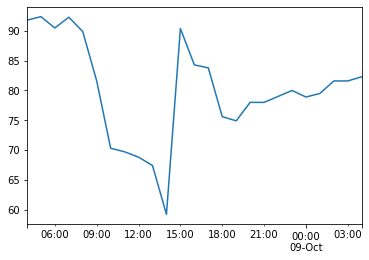

In [125]:
df3.Humidity.plot()

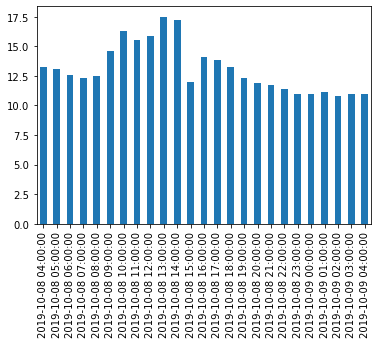

In [126]:
df3.Temperature.plot.bar()

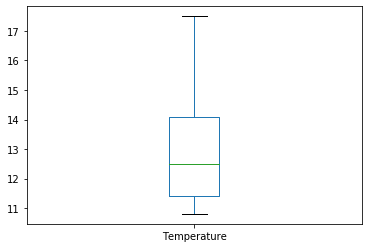

In [127]:
df3.Temperature.plot.box() # Handy!

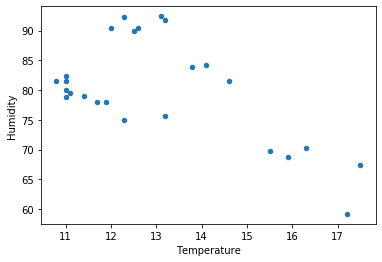

In [128]:
df3.plot.scatter(x='Temperature', y='Humidity') # Spot the problem data point

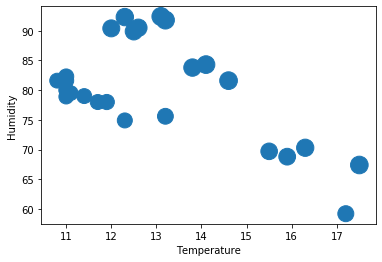

In [129]:
df3.plot.scatter(x='Temperature', y='Humidity', s=(df3.DewPoint+1)*25);

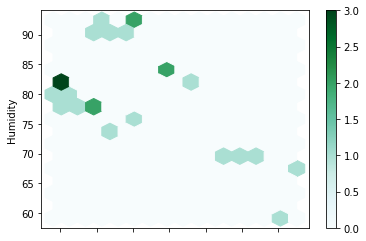

In [130]:
df3.plot.hexbin(x='Temperature', y='Humidity', gridsize=15)

In [131]:
df3.WindDirection.plot() # Ooops.

TypeError: no numeric data to plot

I tend to think that that's quite enough to be coping with for one session... over to the script!

# Appendix

The material below here is very helpful if you _really_ want to get to grips with both some powerful computing concepts (hello recursion!) and to understand how I pulled together the data frame through working with the data iteratively to get to grips with the MetOffice reply. However, it is not _necessary_ that you undertand these ideas now since they are relatively advanced and will be more directly useful in the _Spatial Analysis_ and _Applied Geocomputation_ modules.

## Logical Comparisons

You have already seen a bit of Boolean logic using 'and', 'or', and 'not'. For reasons that aren't really worth getting into here, when you're dealing with the simple binary True/False data (a.k.a. [bit-wise](https://wiki.python.org/moin/BitwiseOperators)) comparisons then the same operations are written using a slightly different syntax:

1. 'and' becomes '&'
2. 'or' becomes '|'
3. 'not' becomes '~'

These are rather topical for complex queries in pandas.

## Using Recursion to Explore JSON Data

We've seen dictionaries-of-lists and dictionaries-of-dictionaries before! We know how these work, but they've never been very easy to work with because we had to write lots and lots of nested loops:

```python
for key1 in bigDictionary:
    for key2 in bigDictionary[key1]:
        for key3 in bigDictionary[key1][key2]:
            ... And so on ...
```

And if we have to add checks on each one of these `keys` to see if it is a list, a dictionary, or a simple float/int then this code would explode in complexity and become very, very hard to follow.

But there is another way. It's a concept called _recursion_. 

Let's imagine that we have to deal with lists-of-lists (because those are a bit simpler to think about) but we don't know in advance how many lists there are inside of each list; e.g.:
```python
myList = [
    ['Value 1',
        ['Value 1.a.i', 'Value 1.a.ii'],
        ['Value 1.b.i', 'Value 1.b.ii', 
            ['Value 1.b.ii.I', 'Value 1.b.ii.II'],
        'Value 1.c'],
    ['Value 2'],
    'Value 3'
]
```
What a nightmare! That's hard to even _read_, let alone know how to process! But recursion allows us reframe this problem as something that is _almost_ simple (it's certainly elegant): we need a function that steps through a list one element at a time and then: 

* if the element is a simple value (float, int or string) then it prints it out, 
* if the element is a list then the function _calls itself_ on the nested list! 

In other words, when our list-reading-function finds a new list _inside_ the list it is currently reading, then it calls itself and passes in the list-inside-the-list.

That explanation probably _still_ doesn't take much sense, but take a look at the code below. 

**Really, really look**:

In [138]:
def outputList(lst, depth=0): 
    for value in lst:
        if type(value) is list:
            outputList(value, depth+1)
        elif type(value) is dict: 
            outputDict(value, depth+1)
        else:
            print("\t" * depth + "l-Value: " + value)
    print("\n")

def outputDict(dct, depth=0):
    for key, value in dct.items():
        print("\t" * depth + "d-Key: " + key)
        if type(value) is list:
            outputList(value, depth+1)
        elif type(value) is dict:
            outputDict(value, depth+1)
        else:
            print("\t" * depth + "  d-Value: " + value)
    print("\n")

So, `outputList` takes a list `l` and then steps through each element of that list. If it encounters an element that is a list, it calls `outputList` and passes it the list that it just found. If it encounters an element that is a dictionary, it calls `outputDict` and passes it the dictionary that it just found. If it encounters a simple value (the `else`) then it just prints it out.

`outputDict` works the same way.

Now, what's going on with `depth`? That is what allows to demonstrate actual recursion, but it contains two _new_ ideas that you'll need to make sense of:

1. It demonstrates that you can have _default values_ in a function. In this case, a call to the `outputList` function _has_ to include a list, but the parameter _depth_ is optional: if you don't specify a depth, then it defaults to 0.
2. You can see that when `outputList` and `outputDict` call _themselves_ they increment the `depth` variable by one.

Let's look at a simpler example:

In [134]:
def showRecursion(depth=0):
    print("\t" * depth + "I'm now at depth " + str(depth))
    if depth < 3:
        showRecursion(depth+1)
    print("\t" * depth + "I'm done with depth " + str(depth))

showRecursion()

I'm now at depth 0
	I'm now at depth 1
		I'm now at depth 2
			I'm now at depth 3
			I'm done with depth 3
		I'm done with depth 2
	I'm done with depth 1
I'm done with depth 0


We use `"\t" * depth` as part of our print statement to indent the output because it multiplies the tab character (`\t`) by the depth (e.g. 1, 2, etc.) to print out 1, 2, 3 tabs. You'll also notice that every time we recurse we increment (increase) depth by 1. So:

* We start at depth 0 with `showRecursion()`.
* We print out "I'm now at depth 0".
* We call `showRecursion(0+1)` (because that's what `depth+1` does)
* We print out "I'm now at depth 1".
* We call `showRecursion(1+1)` (because that's what `depth+1` does)
* ...
* We reach `depth == 3` and so _don't_ call `showRecursion(3+1)` because depth is no longer less than 3.
* _Now_ we print out "I'm done with depth 3" (that's the end of `showRecursion(2+1)`)
* _Now_ we print out "I'm done with depth 2" (that's the end of `showRecursion(1+1)`)
* _Now_ we print out "I'm done with depth 1" (that's the end of `showRecursion(0+1)`)
* _Now_ we print out "I'm done with depth 0" (that's the end of `showRecursion()`)

That's a _lot_ to get your head around, but it's the same as we're doing with `outputList` or `outputDict`. The recursive function helps us to make the formatting legible, so it's probably better that we just see it action... In our case we know that we're starting with a dictionary so we would ask `outputDict` to start outputting the content of `pdesc` (the rePly DESCription). `outputDict` then takes each of the key/value pairs in turn, looks at the value to see if _it_ is a dictionary or list or (by default) string and takes appropriate action. Don't get too stressed out if it doesn't make sense just yet, but it's such a powerful concept that it's definitely worth getting to grips with it.

In [149]:
import json, requests # Libraries we need

api_url  = "http://datapoint.metoffice.gov.uk/public/data/" # base URL
obs_json= "val/wxobs/all/json/" # observations URL

heathrow = str(heathrow)  # heathrow airport weather station

payload = {'res': 'hourly', 'key': api_key} # Dictionary to hold request parameters

r = requests.get(api_url + obs_json + heathrow, params=payload)

print(scrub_api_key(r.url))

weather = r.json() # Capture the reply
pdesc   = weather['SiteRep']['Wx'] # Weather Metadata
pdat    = weather['SiteRep']['DV'] # Weather Data Values
print("Done!")

http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/3772?res=hourly&key=XXX
Done!


In [144]:
outputDict(pdesc)

d-Key: Param
		d-Key: name
		  d-Value: G
		d-Key: units
		  d-Value: mph
		d-Key: $
		  d-Value: Wind Gust


		d-Key: name
		  d-Value: T
		d-Key: units
		  d-Value: C
		d-Key: $
		  d-Value: Temperature


		d-Key: name
		  d-Value: V
		d-Key: units
		  d-Value: m
		d-Key: $
		  d-Value: Visibility


		d-Key: name
		  d-Value: D
		d-Key: units
		  d-Value: compass
		d-Key: $
		  d-Value: Wind Direction


		d-Key: name
		  d-Value: S
		d-Key: units
		  d-Value: mph
		d-Key: $
		  d-Value: Wind Speed


		d-Key: name
		  d-Value: W
		d-Key: units
		  d-Value: 
		d-Key: $
		  d-Value: Weather Type


		d-Key: name
		  d-Value: P
		d-Key: units
		  d-Value: hpa
		d-Key: $
		  d-Value: Pressure


		d-Key: name
		  d-Value: Pt
		d-Key: units
		  d-Value: Pa/s
		d-Key: $
		  d-Value: Pressure Tendency


		d-Key: name
		  d-Value: Dp
		d-Key: units
		  d-Value: C
		d-Key: $
		  d-Value: Dew Point


		d-Key: name
		  d-Value: H
		d-Key: units
		  d-Value: %
		d-Key: $
		  d-Value: Screen Relativ

OK, so what we have is:

* A dictionary saved in the variable `pdesc` (parameter-description)
* It contains one key only: `Param`
* `pdesc['Param']` is a list of dictionaries

How do I know this? I investigated...

In [145]:
print("Type for pdesc['Param']: " + str(type(pdesc['Param'])))

print("Type for pdesc['Param'][0]: " + str(type(pdesc['Param'][0])))

print("Contents of pdesc['Param'][0]: " + str(pdesc['Param'][0]))

Type for pdesc['Param']: <class 'list'>
Type for pdesc['Param'][0]: <class 'dict'>
Contents of pdesc['Param'][0]: {'name': 'G', 'units': 'mph', '$': 'Wind Gust'}


So the point here is that we know have little bundles of information about the data the MetOffice is giving back to us: the parameter description dictionary tells us, for instance, that the name 'G' in the data-part of the reply is data about 'wind gusts' given in miles per hour ('mph'). We can do the same for every other parameter.

Now, let's see what we get when we look at the data values:

In [150]:
outputDict(pdat)

d-Key: dataDate
  d-Value: 2019-10-09T05:00:00Z
d-Key: type
  d-Value: Obs
d-Key: Location
	d-Key: i
	  d-Value: 3772
	d-Key: lat
	  d-Value: 51.479
	d-Key: lon
	  d-Value: -0.449
	d-Key: name
	  d-Value: HEATHROW
	d-Key: country
	  d-Value: ENGLAND
	d-Key: continent
	  d-Value: EUROPE
	d-Key: elevation
	  d-Value: 25.0
	d-Key: Period
			d-Key: type
			  d-Value: Day
			d-Key: value
			  d-Value: 2019-10-08Z
			d-Key: Rep
					d-Key: D
					  d-Value: WSW
					d-Key: H
					  d-Value: 92.4
					d-Key: P
					  d-Value: 1008
					d-Key: S
					  d-Value: 9
					d-Key: T
					  d-Value: 13.1
					d-Key: V
					  d-Value: 12000
					d-Key: W
					  d-Value: 7
					d-Key: Pt
					  d-Value: F
					d-Key: Dp
					  d-Value: 11.9
					d-Key: $
					  d-Value: 300


					d-Key: D
					  d-Value: SW
					d-Key: H
					  d-Value: 90.5
					d-Key: P
					  d-Value: 1008
					d-Key: S
					  d-Value: 9
					d-Key: T
					  d-Value: 12.6
					d-Key: V
					  d-Value: 11000
					d-Key: W
					  d-V

Right, so that's a lot more complex isn't it? But we can make sense of it in the same incremental way...

We can start off by noticing that there are some useful _generic_ fields:

* `pdat['dataDate']` will give us the date and time of the data in the reply.
* `pdat['type']` tells us that we're looking at _Obs_-ervations

And so on. The really interesting one in there is the 'Location'... let's investigate:

In [153]:
print(pdat['Location']['name'])
print(pdat['Location']['elevation'])
print(pdat['Location']['lat'])
print(pdat['Location']['lon'])

HEATHROW
25.0
51.479
-0.449


That leaves us with the rather nasty-looking `pdat['Location']['Period']`:

In [154]:
pdat['Location']['Period']

[{'type': 'Day',
  'value': '2019-10-08Z',
  'Rep': [{'D': 'WSW',
    'H': '92.4',
    'P': '1008',
    'S': '9',
    'T': '13.1',
    'V': '12000',
    'W': '7',
    'Pt': 'F',
    'Dp': '11.9',
    '$': '300'},
   {'D': 'SW',
    'H': '90.5',
    'P': '1008',
    'S': '9',
    'T': '12.6',
    'V': '11000',
    'W': '0',
    'Pt': 'R',
    'Dp': '11.1',
    '$': '360'},
   {'D': 'SW',
    'H': '92.3',
    'P': '1008',
    'S': '9',
    'T': '12.3',
    'V': '11000',
    'W': '3',
    'Pt': 'F',
    'Dp': '11.1',
    '$': '420'},
   {'D': 'WSW',
    'H': '89.9',
    'P': '1007',
    'S': '11',
    'T': '12.5',
    'V': '12000',
    'W': '7',
    'Pt': 'F',
    'Dp': '10.9',
    '$': '480'},
   {'D': 'SW',
    'H': '81.6',
    'P': '1007',
    'S': '15',
    'T': '14.6',
    'V': '11000',
    'W': '1',
    'Pt': 'F',
    'Dp': '11.5',
    '$': '540'},
   {'D': 'WSW',
    'H': '70.3',
    'P': '1007',
    'S': '16',
    'T': '16.3',
    'V': '16000',
    'W': '7',
    'Pt': 'F',
    'Dp

Again, however, if we don't panic then we can make sense of it! First, let's look at the big pieces:

* It's pretty obvious that there's a set of dictionaries in there -- we can see the '{...}'!
* We can also see things that look like readings: 'D', 'Dp', 'H', 'P'...
* We can also see two rather useful-looking bits of information: something that says 'Day' and something that looks like a timestamp (e.g. '2016-10-14Z')

Let's work on this some more by trial-and-error, starting from the point that the data structure must be a list because of the '[...]':

In [151]:
outputDict(pdat['Location']['Period'][0], 0)

d-Key: type
  d-Value: Day
d-Key: value
  d-Value: 2019-10-08Z
d-Key: Rep
		d-Key: D
		  d-Value: WSW
		d-Key: H
		  d-Value: 92.4
		d-Key: P
		  d-Value: 1008
		d-Key: S
		  d-Value: 9
		d-Key: T
		  d-Value: 13.1
		d-Key: V
		  d-Value: 12000
		d-Key: W
		  d-Value: 7
		d-Key: Pt
		  d-Value: F
		d-Key: Dp
		  d-Value: 11.9
		d-Key: $
		  d-Value: 300


		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 90.5
		d-Key: P
		  d-Value: 1008
		d-Key: S
		  d-Value: 9
		d-Key: T
		  d-Value: 12.6
		d-Key: V
		  d-Value: 11000
		d-Key: W
		  d-Value: 0
		d-Key: Pt
		  d-Value: R
		d-Key: Dp
		  d-Value: 11.1
		d-Key: $
		  d-Value: 360


		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 92.3
		d-Key: P
		  d-Value: 1008
		d-Key: S
		  d-Value: 9
		d-Key: T
		  d-Value: 12.3
		d-Key: V
		  d-Value: 11000
		d-Key: W
		  d-Value: 3
		d-Key: Pt
		  d-Value: F
		d-Key: Dp
		  d-Value: 11.1
		d-Key: $
		  d-Value: 420


		d-Key: D
		  d-Value: WSW
		d-Key: H
		  d-Value: 89.9
		d-Key: P
		  d-Va

In [152]:
outputDict(pdat['Location']['Period'][1], 0)

d-Key: type
  d-Value: Day
d-Key: value
  d-Value: 2019-10-09Z
d-Key: Rep
		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 78.9
		d-Key: P
		  d-Value: 1006
		d-Key: S
		  d-Value: 13
		d-Key: T
		  d-Value: 11.0
		d-Key: V
		  d-Value: 23000
		d-Key: W
		  d-Value: 7
		d-Key: Pt
		  d-Value: F
		d-Key: Dp
		  d-Value: 7.5
		d-Key: $
		  d-Value: 0


		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 79.5
		d-Key: P
		  d-Value: 1006
		d-Key: S
		  d-Value: 14
		d-Key: T
		  d-Value: 11.1
		d-Key: V
		  d-Value: 23000
		d-Key: W
		  d-Value: 7
		d-Key: Pt
		  d-Value: F
		d-Key: Dp
		  d-Value: 7.7
		d-Key: $
		  d-Value: 60


		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 81.6
		d-Key: P
		  d-Value: 1005
		d-Key: S
		  d-Value: 9
		d-Key: T
		  d-Value: 10.8
		d-Key: V
		  d-Value: 22000
		d-Key: W
		  d-Value: 7
		d-Key: Pt
		  d-Value: F
		d-Key: Dp
		  d-Value: 7.8
		d-Key: $
		  d-Value: 120


		d-Key: D
		  d-Value: SW
		d-Key: H
		  d-Value: 81.6
		d-Key: P
		  d-Value: 1

OK, now we know that `pdat['Location']['Period']` is a list of daily reports. How do I know that? Because when I asked for the first item in the list I got an answer with yesterday's date, and when I asked for the second item in the list I got something containing today's date! And _within_ each of those is _another_ list that contains a set of reports about the weather at Heathrow!

The _last_ clue in there is that one of the parameters is changing in an unusal way: we can guess what H (Humidity), P (Pressure) and most of the rest are from having output `pdesc` above, but the '$' is always in multiples of 60. Can you guess why?

Let's see if we can turn this into something useful... Fix the '???' so that prints out the temperature reading at Heathrow.

In [157]:
for d in pdat['Location']['Period']: # d is short for day
    print("Date: " + d['value'])
    for i in d['Rep']: # i is short for time interval
        print("\tTime: " + str(i['$']))
        print("\t\tTemperature is: " + str(i["T"]))
        print("\t\tHumidity is:    " + str(i["H"]))

Date: 2019-10-08Z
	Time: 300
		Temperature is: 13.1
		Humidity is:    92.4
	Time: 360
		Temperature is: 12.6
		Humidity is:    90.5
	Time: 420
		Temperature is: 12.3
		Humidity is:    92.3
	Time: 480
		Temperature is: 12.5
		Humidity is:    89.9
	Time: 540
		Temperature is: 14.6
		Humidity is:    81.6
	Time: 600
		Temperature is: 16.3
		Humidity is:    70.3
	Time: 660
		Temperature is: 15.5
		Humidity is:    69.7
	Time: 720
		Temperature is: 15.9
		Humidity is:    68.8
	Time: 780
		Temperature is: 17.5
		Humidity is:    67.4
	Time: 840
		Temperature is: 17.2
		Humidity is:    59.2
	Time: 900
		Temperature is: 12.0
		Humidity is:    90.4
	Time: 960
		Temperature is: 14.1
		Humidity is:    84.3
	Time: 1020
		Temperature is: 13.8
		Humidity is:    83.8
	Time: 1080
		Temperature is: 13.2
		Humidity is:    75.6
	Time: 1140
		Temperature is: 12.3
		Humidity is:    74.9
	Time: 1200
		Temperature is: 11.9
		Humidity is:    78.0
	Time: 1260
		Temperature is: 11.7
		Humidity is:    78.0
	Time: 1

Can you explain why there are two days in there and why the '$' values don't overal?

Use the coding area below to print out the other values over the same period of time...

## Working with Time Data

To really deal with the Weather data we need to know how to work with dates and times. Naturally, Python has a library that can help with that so let's first have a look at the obvious date in there: `dataDate`.

In [158]:
from datetime import datetime, timedelta 

# Ignore the time part of 'dataDate' as we're 
# getting API data with values in minutes after
# midnight. Given that, we want to set this 
# starting point to 00:00:00Z
obsDate = datetime.strptime(pdat['dataDate'].split("T")[0],'%Y-%m-%d')

print(obsDate)
print(type(obsDate)) # It's a new type of object... beyond float, int, etc.

2019-10-09 00:00:00
<class 'datetime.datetime'>


OK, that's a start, now let's see if we can do two more things:

1. Do 'date math' so that we can add the number of minutes since midnight associated with the observation to the datetime object extracted from `dataDate`.
2. Print out _one_ observation from the full range.

We do this as a 'nested' loop: we know that we have one 'period' for each day contained in the data. And we know that within each day we have one 'report' for each hour. We can't (and don't want to) go through these in a random order so we use two `for` loops:

```python
for d in <day>:
    for h in <hour>:
        ...do something...
```

In [159]:
for d in pdat['Location']['Period']: # d is for day of observations
    
    dataDate = datetime.strptime(d['value'],'%Y-%m-%dZ') # Convert date to datetime object
    print("Observation date: " + str(dataDate)) # Print for debugging
    
    for h in d['Rep']: # h is for hourly reports
        obsDate = dataDate + timedelta(minutes = int(h['$'])) # Add the time in minutes to the datetime
        # print(obsDate) # Debug!
        
        print("Temperature at " + str(obsDate) + " is " + str(h['T']))

Observation date: 2019-10-08 00:00:00
Temperature at 2019-10-08 05:00:00 is 13.1
Temperature at 2019-10-08 06:00:00 is 12.6
Temperature at 2019-10-08 07:00:00 is 12.3
Temperature at 2019-10-08 08:00:00 is 12.5
Temperature at 2019-10-08 09:00:00 is 14.6
Temperature at 2019-10-08 10:00:00 is 16.3
Temperature at 2019-10-08 11:00:00 is 15.5
Temperature at 2019-10-08 12:00:00 is 15.9
Temperature at 2019-10-08 13:00:00 is 17.5
Temperature at 2019-10-08 14:00:00 is 17.2
Temperature at 2019-10-08 15:00:00 is 12.0
Temperature at 2019-10-08 16:00:00 is 14.1
Temperature at 2019-10-08 17:00:00 is 13.8
Temperature at 2019-10-08 18:00:00 is 13.2
Temperature at 2019-10-08 19:00:00 is 12.3
Temperature at 2019-10-08 20:00:00 is 11.9
Temperature at 2019-10-08 21:00:00 is 11.7
Temperature at 2019-10-08 22:00:00 is 11.4
Temperature at 2019-10-08 23:00:00 is 11.0
Observation date: 2019-10-09 00:00:00
Temperature at 2019-10-09 00:00:00 is 11.0
Temperature at 2019-10-09 01:00:00 is 11.1
Temperature at 2019-1

See how that worked? We did the following:

1. For each day `d` in the data...
2. We used the `value` parameter to initialise (i.e. set) a variable called `dataDate`
3. We then retrieved the 'hours since midnight' from the \$ parameter and added it to dataDate using the `timedelta` function.
4. And then we found the temperature using the `T` key.